In [9]:
import numpy as np
import os
import math

from PIL import Image

# Clustering
from sklearn.cluster import AgglomerativeClustering # 1) Agglomerative-Hierarchical
from sklearn.cluster import KMeans                  # 2) K-Means
from sklearn.mixture import GaussianMixture         # 3) Gaussian Mixture Models

from skimage.color import rgb2hed
from sklearn.preprocessing import StandardScaler
# Evaluation
from sklearn import metrics
from skimage.external import tifffile
from skimage.measure import compare_mse
from skimage.metrics import structural_similarity as ssim
from sklearn.decomposition import PCA, KernelPCA               # 2) PCA

import matplotlib.pyplot as plt 
%matplotlib inline

In [20]:
def calculateMeanHE(image):
    hedImage = rgb2hed(image) # hed is short for Hematox, Eosin, DAB
    hemaValues = hedImage[:, :, 0]
    eosValues = hedImage[:, :, 1]
    return [hemaValues.mean(), eosValues.mean()]

def calculateMeanRGB(image):
    pixels = image.load()
    width, height = image.size 
    num_pixels = width * height
    r_mean = g_mean = b_mean = 0 
    for i in range(width):
        for j in range(height): 
            r,g,b=pixels[i,j] 
            r_mean += r
            g_mean += g
            b_mean += b
    return [r_mean/num_pixels , g_mean/num_pixels , b_mean/num_pixels]

def ClusterAndPlot(n_clusters, D):
    Labels = []
    
    print(D.shape)
    HC = AgglomerativeClustering(n_clusters=n_clusters, affinity='manhattan', linkage='complete').fit(D)
    print('HC Silhouette Score  {} '.format(metrics.silhouette_score(D, HC.labels_)))

    kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(D)
    print('kmeans Silhouette Score  {} '.format(metrics.silhouette_score(D, kmeans.labels_)))

    gmm = GaussianMixture(n_components=n_clusters, covariance_type='full').fit(D)
    gmmlabels_ = gmm.predict(D)
    print('gmm Silhouette Score  {} '.format(metrics.silhouette_score(D, gmmlabels_)))
    
    fig, axs = plt.subplots(2, 2, figsize=(13, 7))
    axs[0, 0].scatter(D[:, 0], D[:, 1], cmap='viridis')
    axs[0, 0].set_title('Normal')

    axs[0, 1].scatter(D[:, 0], D[:, 1], c=gmmlabels_, cmap='viridis')
    axs[0, 1].set_title('GMM')

    axs[1, 0].scatter(D[:, 0], D[:, 1], c=kmeans.labels_, cmap='viridis')
    axs[1, 0].set_title('K-Means')

    axs[1, 1].scatter(D[:, 0], D[:, 1], c=HC.labels_, cmap='viridis')
    axs[1, 1].set_title('HC')
    plt.show()
    
    Labels.append(HC.labels_)
    Labels.append(kmeans.labels_)
    Labels.append(gmmlabels_)
    return Labels


def pltPathologyClusters(labels):
    clusterimgDir = "../../Data/clusters_journal.PNG"
    image = Image.open(clusterimgDir) 
    plt.figure(figsize = (85,12))
    plt.imshow(image)
    plt.axis('off')
    
    sub_directories = [str(cluster) for cluster in set(labels)]
    displayImages = []
    mseList = [] # matrix of images, each row is a cluster
    valMse = []
    valSsim = []
    
    for cluster in sub_directories:
        direct = directory + '/{}'.format(cluster)
#         if len(os.listdir(direct))-9 > 9: # if directory has less than 9 images set index to 0 else random index
#             index = np.random.randint(9,len(os.listdir(direct))-9)
#         else:
        index = 0 # pick the first 10 images
        clusterList = [] # reset the row
        for file in os.listdir(direct)[index:index+9]: # random sample of 9 images
            if file.endswith('.tif'):
                #image = Image.open(os.path.join(trainData, file)) 
                image = tifffile.imread(os.path.join(directory, file))
                clusterList.append(image)
                displayImages.append(image) # list of ALL Images
        mseList.append(clusterList)
        
#         print(mseList)
#         print("Size of cluster {} is {}".format(str(cluster),len(os.listdir(direct))))
#         print("Taking images with the indices {} to {}\n".format(index, index+9))
    for clusterRow in mseList:
        SumMse = 0
        SumSsim = 0
        for i in range(0,7,2):
            val = compare_mse(clusterRow[i], clusterRow[i+1])
            valssim = ssim(clusterRow[i], clusterRow[i+1], multichannel=True)
            SumMse += val
            SumSsim += valssim
        valMse.append(math.ceil(SumMse / 4))
        valSsim.append(SumSsim / 4)
            
    
    fig = plt.figure(figsize=(14, 14))
    
    columns = 9
    rows = len(sub_directories)
    print(len(displayImages))
    print(columns*rows+1)
    for i in range(1, columns*rows+1):
        img = displayImages[i-1]
        fig.add_subplot(rows, columns, i)
        plt.imshow(img)
        plt.axis('off')
        plt.subplots_adjust(wspace=0.0, hspace=0.0)
#     plt.show()
    
    return [valMse, sum(valMse)/len(valMse),valSsim, sum(valSsim)/len(valSsim)]

def symlink_rel(src, dst):
    rel_path_src = os.path.relpath(src, os.path.dirname(dst))
    os.symlink(rel_path_src, dst)

def clusterintoDirectories(labels):
    sub_directories = [str(cluster) for cluster in set(labels)]

    for filename in os.listdir(directory):
        if filename.endswith('.tif'):
            for cluster in sub_directories: # count of distinct elements = no. of clusters
                os.makedirs(directory + '/{}'.format(cluster) , exist_ok=True)

    for i in range(len(image_names)):
        # if there isnt already a symlink of this image in the coressponding subdirectory
        if image_names[i] not in os.listdir(directory + '/' + sub_directories[labels[i]]): 
            symlink_rel(directory + '/{}'.format(image_names[i]) , 
                       directory + '/{}'.format(labels[i]) + '/' + image_names[i])


In [3]:
directory = "../../Data/train"
mean_List = []
image_names = []

for filename in os.listdir(directory):
    if filename.endswith('tif') :
        image = Image.open(os.path.join(directory, filename))
        image_names.append(filename)
        mean_List.append(calculateMeanHE(image) + calculateMeanRGB(image))


(9999, 5)
HC Silhouette Score  0.24804558244032157 
kmeans Silhouette Score  0.3480931716655638 
gmm Silhouette Score  0.2125447569032277 


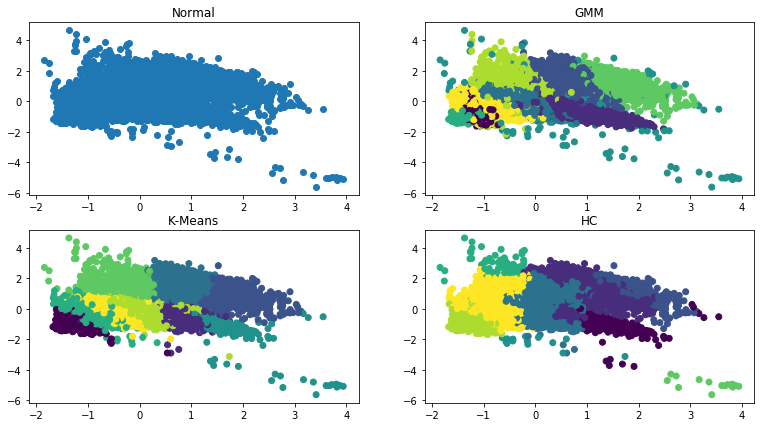

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:89: UserWarning: DEPRECATED: skimage.measure.compare_mse has been moved to skimage.metrics.mean_squared_error. It will be removed from skimage.measure in version 0.18.


81
82


[[7955, 8158, 6518, 4588, 4323, 4363, 6090, 5311, 6559],
 [0.03771318462143586,
  0.022367987336614083,
  0.03463214791757999,
  0.040445270625565605,
  0.02578525078314072,
  0.03766079826188314,
  0.029573557362287138,
  0.0217934988519091,
  0.02106171481598229]]

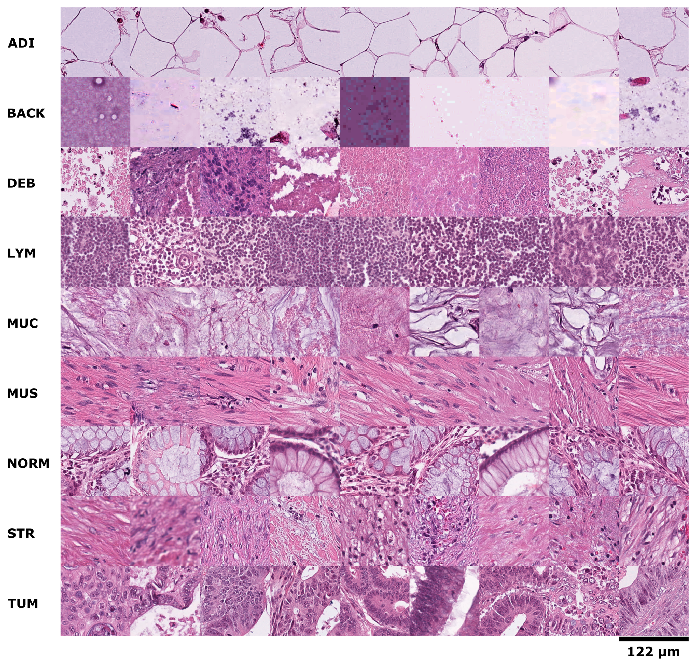

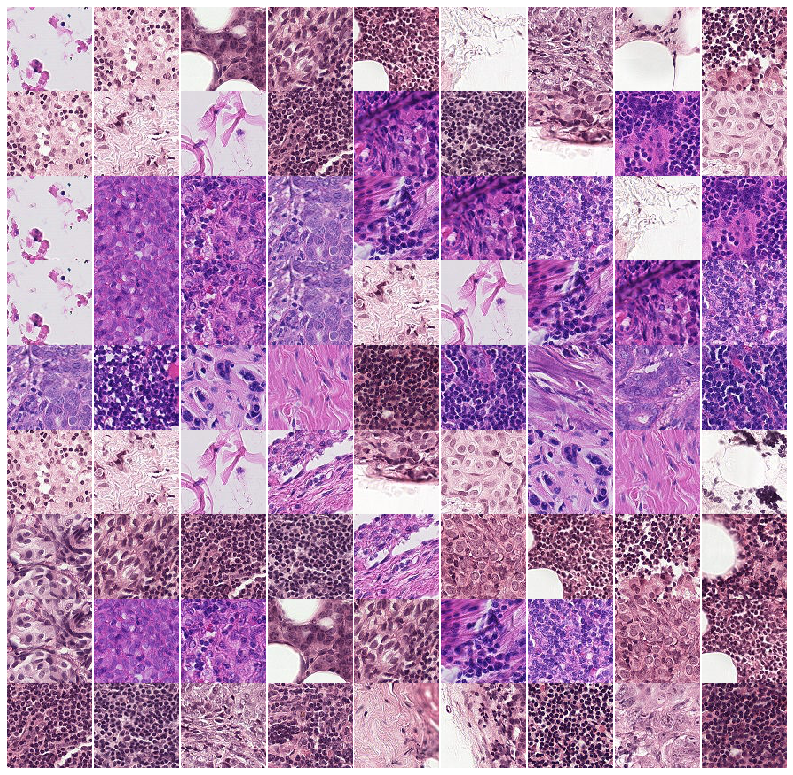

In [21]:
meanMatrix = np.asarray(mean_List)

# Standardize the dataset by removing the mean and scaling to unit variance z =(x-u)/s
scaler = StandardScaler()
scaledData = scaler.fit_transform(meanMatrix)

Labels = ClusterAndPlot(9, scaledData)
clusterintoDirectories(Labels[1])
valMse = pltPathologyClusters(Labels[1])
valMse

(9999, 2)
HC Silhouette Score  0.292965593477434 
kmeans Silhouette Score  0.3970964324555844 
gmm Silhouette Score  0.3566804918391158 


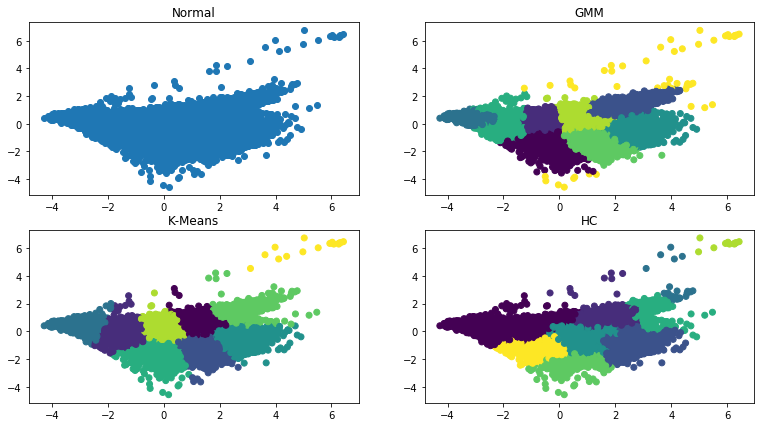

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:89: UserWarning: DEPRECATED: skimage.measure.compare_mse has been moved to skimage.metrics.mean_squared_error. It will be removed from skimage.measure in version 0.18.


81
82


[[7955, 8158, 6518, 4588, 4323, 4363, 6090, 5311, 6559],
 [0.03771318462143586,
  0.022367987336614083,
  0.03463214791757999,
  0.040445270625565605,
  0.02578525078314072,
  0.03766079826188314,
  0.029573557362287138,
  0.0217934988519091,
  0.02106171481598229]]

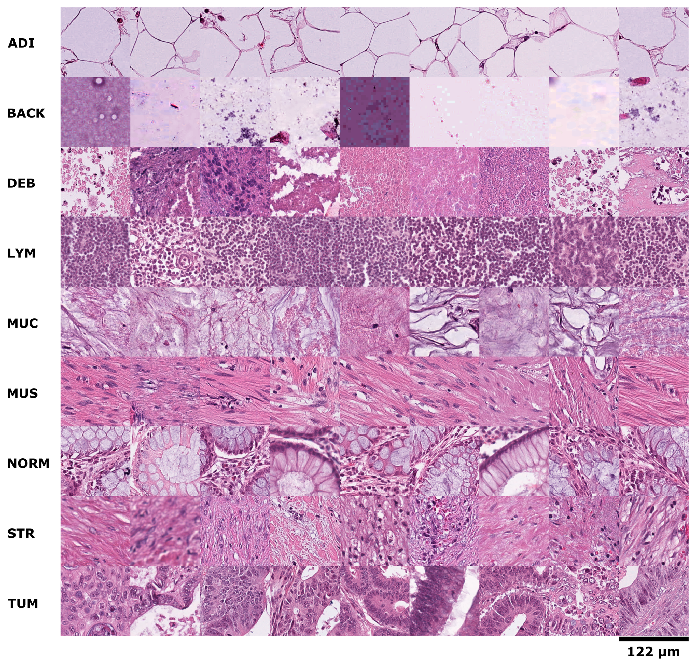

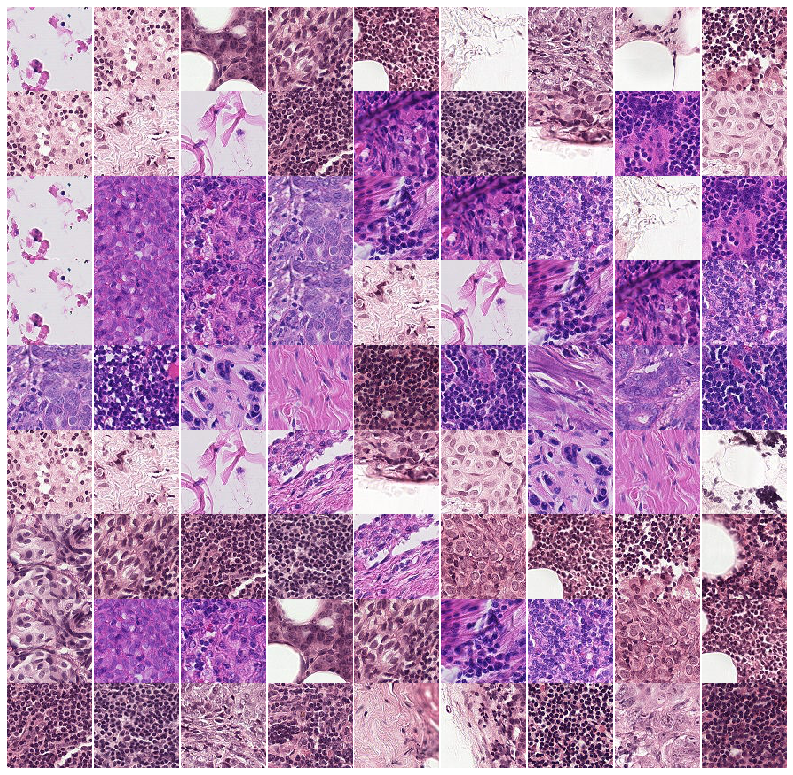

In [22]:
# PCA 
pca = PCA(n_components=2)
transformedData = pca.fit_transform(scaledData)

Labels = ClusterAndPlot(9, transformedData)
clusterintoDirectories(Labels[1])
valMse = pltPathologyClusters(Labels[1])
valMse

In [23]:
pca.explained_variance_ratio_

array([0.75249227, 0.20307271])